Las diferencias son las siguientes:

Discriminador:

la arquitectura 1 utiliza una capa de Dropout después de la capa Flatten. En la arquitectura 2, esta capa de Dropout no se incluye.
En la arquitectura 1, el discriminador tiene una capa densa final con una sola unidad y activación sigmoide. En la arquitectura 2, se agrega una capa adicional de convolución con 512 filtros antes de la capa Flatten, lo que permite una representación más profunda y compleja.
Generador:

En la arquitectura 1, el generador utiliza una capa densa inicial con una cantidad de nodos calculada en base al tamaño del espacio latente. En la arquitectura 2, se utiliza una capa densa con una cantidad fija de nodos (4 * 4 * 256) y se especifica el tamaño del espacio latente como entrada_dim.
La arquitectura 1 y la 2 tienen la misma estructura básica después de la capa densa inicial, con capas de convolución transpuesta y activaciones LeakyReLU. Sin embargo, en la arquitectura 2 se utilizan más filtros en las capas de convolución transpuesta para capturar características más complejas.
En general, la arquitectura 2 tiene una estructura más profunda y utiliza más filtros en las capas convolucionales para capturar características más complejas en las imágenes de 32x32 píxeles. Esto puede ayudar a mejorar el rendimiento y la calidad de las imágenes generadas.

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ruta al directorio de imágenes descargadas
directorio_imagenes = "/content/drive/MyDrive/dataset"  # Reemplaza con el directorio correcto

# Lista para almacenar las imágenes y las etiquetas
imagenes = []
etiquetas = []

# Recorre el directorio de imágenes y carga las imágenes en la lista
for nombre_archivo in os.listdir(directorio_imagenes):
    if nombre_archivo.endswith(".jpg"):
        ruta_imagen = os.path.join(directorio_imagenes, nombre_archivo)

        # Verifica si la imagen se puede leer correctamente
        imagen = cv2.imread(ruta_imagen)
        if imagen is None:
            print(f"Error al leer la imagen: {ruta_imagen}")
            continue

        # Verifica si la imagen tiene dimensiones válidas antes de redimensionarla
        if imagen.shape[0] < 32 or imagen.shape[1] < 32:
            print(f"Dimensiones inválidas para la imagen: {ruta_imagen}")
            continue

        imagen = cv2.resize(imagen, (32, 32))  # Redimensiona la imagen a 32x32 píxeles
        imagenes.append(imagen)
        etiquetas.append(1)  # Reemplaza esto con la etiqueta adecuada para cada imagen

# Convierte las listas en matrices numpy
X = np.array(imagenes)
y = np.array(etiquetas)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliza los valores de píxeles
trainX = X_train / 255.0
testX = X_test / 255.0

# Ajusta las dimensiones de las matrices de etiquetas
trainy = np.reshape(y_train, (-1, 1))
testy = np.reshape(y_test, (-1, 1))


def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compilar el modelo
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Tamaño del espacio latente
latent_dim = 100

# Crear el discriminador
discriminator = define_discriminator()
discriminator.summary()

# Crear el generador
generator = define_generator(latent_dim)
generator.summary()

# Crear el modelo GAN
gan_model = define_gan(generator, discriminator)
gan_model.summary()

# Entrenamiento

# Configuración de hiperparámetros
n_epochs = 50
n_batch = 64
bat_per_epo = int(trainX.shape[0] / n_batch)

# Carga y preprocesa los datos de entrenamiento utilizando tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy))
train_dataset = train_dataset.shuffle(buffer_size=trainX.shape[0]).batch(n_batch)

# Bucle de entrenamiento
for epoch in range(n_epochs):
    for batch, (X_real, y_real) in enumerate(train_dataset):
        # Entrenar el discriminador en datos reales
        d_loss1, _ = discriminator.train_on_batch(X_real, y_real)

        # Generar datos falsos
        X_gan = tf.random.normal(shape=(n_batch, latent_dim))
        X_fake = generator.predict(X_gan)
        y_fake = np.zeros((n_batch, 1))

        # Entrenar el discriminador en datos falsos
        d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)

        # Entrenar el generador
        X_gan = tf.random.normal(shape=(n_batch, latent_dim))
        y_gan = np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)

        # Imprimir progreso
        print(f"Epoch: {epoch+1}/{n_epochs}, Batch: {batch}/{bat_per_epo}, D_loss_real: {d_loss1}, D_loss_fake: {d_loss2}, G_loss: {g_loss}")




Error al leer la imagen: /content/drive/MyDrive/dataset/pothole1.jpg
Error al leer la imagen: /content/drive/MyDrive/dataset/299.jpg
Error al leer la imagen: /content/drive/MyDrive/dataset/478.jpg
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_120 (LeakyReLU)  (None, 16, 16, 64)       0         
                                                                 
 conv2d_73 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_121 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 4, 4, 256)         295168    
                                                      

In [22]:
# Guardar el generador
generator.save('/content/drive/MyDrive/generator_model_2.h5')

1/1 [==============================] - 0s 128ms/step


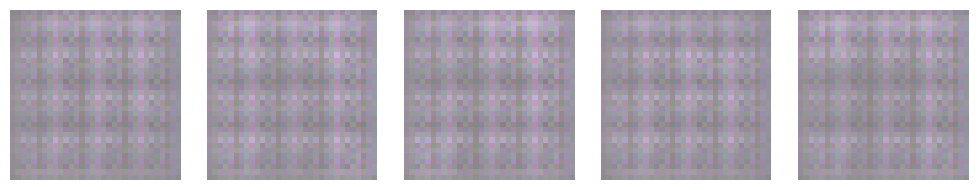

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Cargar el modelo del generador
generator = load_model('/content/drive/MyDrive/generator_model_2.h5')

# Tamaño del espacio latente
latent_dim = 100

# Generar muestras latentes aleatorias
latent_points = np.random.normal(size=(5, latent_dim))

# Generar imágenes falsas
fake_images = generator.predict(latent_points)
fake_images = (fake_images + 1) / 2.0

# Mostrar las imágenes generadas
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(fake_images[i])

plt.tight_layout()
plt.show()
